# Знакомство с данными

In [24]:
# Необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Вспомогательные библиотеки
import re
# Отключил пердупреждения для чистоты вывода
from warnings import filterwarnings
filterwarnings("ignore")
# Легче читаемые числа после расчётов
pd.set_option('display.float_format', lambda x: '%.2f' %x)

In [25]:
main = pd.read_csv('data/poverty_percent_by_regions_1992_2020.csv')
main

,region,year,poverty_percent
0,Российская Федерация,1992,33.50
1,Российская Федерация,1993,31.30
2,Российская Федерация,1994,22.40
3,Российская Федерация,1995,24.80
4,Российская Федерация,1996,22.10
...,...,...,...
2334,Чукотский автономный округ,2017,8.50
2335,Чукотский автономный округ,2018,8.80
2336,Чукотский автономный округ,2019,8.50
2337,Чукотский автономный округ,2020,8.00


In [26]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region           2339 non-null   object 
 1   year             2339 non-null   int64  
 2   poverty_percent  2339 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 54.9+ KB


Данные не содержат пропусков, типы данных присвоены правильно

In [27]:
main.describe()

,year,poverty_percent
count,2339.00,2339.00
mean,2007.80,20.24
std,7.43,13.36
min,1992.00,0.00
25%,2002.00,12.50
50%,2008.00,17.30
75%,2014.00,25.50
max,2020.00,98.40


Данные за 1992-2020 год, процент бедности от 0 до 98.4%

In [28]:
# Так как данные по следующим областям представлены в агрегированном виде до 2012 года, отставлю их так и удалю аггрегированные после 2011
main['region'] = main['region'].apply(lambda x: x.strip())
main = main[~main.index.isin(
    main[(main['region'] == 'Архангельская область')][main.year > 2011].index)]
main = main[~main.index.isin(
    main[(main['region'] == 'Тюменская область')][main.year > 2011].index)]
short_dict = {'Архангельская область': 'Архангельская область (кроме Ненецкого автономного округа)',
              'Тюменская область': 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'}
main.region = main.region.apply(
    lambda x: short_dict[x] if x in short_dict else x)

In [29]:
# Сохраню отдельно данные по РФ перед удалением
rf_main = main[main.region == 'Российская Федерация']

In [30]:
def unified_regions(df):
    '''функция для отбора нужных регионов
    дополняется по мере знакомства с датасетами'''
    df = df.dropna(subset='region')
    df['region'] = df['region'].apply(lambda x: x.strip())
    # Удалим аггрегационные данные (округа и две области, содержащие регионы)
    df = df.loc[~(df['region'].str.contains('федеральный')) &
                ~(df['region'] == 'Архангельская область') &
                ~(df['region'] == 'Тюменская область') &
                ~(df['region'] == 'Российская Федерация'), :]

    # Сократим названия
    def find_similar(s):
        mydict = {'оскв': 'Город Москва',
                  'етербург': 'Город Санкт-Петербург',
                  'евастополь': 'Город Севастополь',
                  'город Севастополь': 'Город Севастополь',
                  'Архангельская область ': 'Архангельская область [кроме..]',
                  'Тюменская область ': 'Тюменская область [кроме..]',
                  'Чувашская Республика': 'Чувашская Республика - Чувашия',
                  'Ханты-Мансийский авт': 'Ханты-Мансийский автономный округ - Югра',
                  'Кемеровская область': 'Кемеровская область - Кузбасс',
                  ' Саха': 'Республика Саха'}
        for key in mydict:
            if key in s:
                return (mydict[key])
        return (s)
    df.region = df.region.apply(find_similar)
    df.region = df.region.apply(lambda x: re.sub(
        r' \([^)]*\)|\[[^\]]*\]|\{[^}]*\}', '', x))
    df.region = df.region.str.replace('авт. округ', 'автономный округ')
    df.region = df.region.str.replace('авт. область', 'автономная область')
    df.region = df.region.str.replace('B', 'В')
    return df

In [31]:
main = unified_regions(main)

In [32]:
main['poverty_percent'].value_counts(dropna=False)

poverty_percent
0.00     36
14.20    22
13.60    21
14.90    21
13.00    19
         ..
68.90     1
55.20     1
46.20     1
44.30     1
50.10     1
Name: count, Length: 474, dtype: int64

In [33]:
# Пробовал разные подходы к замене нулей, но в результате вижу самым логичным от них избавиться. Cделаю это после построения карты, а то некрасиво получается)
# main = main.replace(0,np.nan).dropna()

# EDA

## Интерактивная карта

Добавим регионы для отрисовки

In [34]:
# Код на географические координаты брал в интернете (может можно оптимизировать, но не хочу менять то, что работает)
# Красивое, но лагает, раскомментить при необходимости или очистить вывод после просмотра
'''from urllib.request import urlopen
import json
import requests
with urlopen('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/russia.geojson') as response:
    counties = json.load(response)


regions_republic_1 = ['Бурятия', 'Тыва', 'Адыгея', 'Татарстан', 'Марий Эл', 'Алтай',
                      'Дагестан', 'Ингушетия', 'Башкортостан']
regions_republic_2 = ['Удмуртская республика', 'Кабардино-Балкарская республика',
                      'Карачаево-Черкесская республика', 'Чеченская республика']
for k in range(len(counties['features'])):
    counties['features'][k]['id'] = k
    if counties['features'][k]['properties']['name'] in regions_republic_1:
        counties['features'][k]['properties']['name'] = 'Республика ' + \
            counties['features'][k]['properties']['name']
    elif counties['features'][k]['properties']['name'] in regions_republic_2:
        counties['features'][k]['properties']['name'] = counties['features'][k]['properties']['name'].title()
    elif counties['features'][k]['properties']['name'] == 'Архангельская область':
        counties['features'][k]['properties']['name'] = 'Архангельская область [кроме..]'
    elif counties['features'][k]['properties']['name'] == 'Тюменская область':
        counties['features'][k]['properties']['name'] = 'Тюменская область [кроме..]'
    elif counties['features'][k]['properties']['name'] == 'Северная Осетия - Алания':
        counties['features'][k]['properties']['name'] = 'Республика Северная Осетия-Алания'
    elif counties['features'][k]['properties']['name'] == 'Чувашия':
        counties['features'][k]['properties']['name'] = 'Чувашская Республика - Чувашия'
    elif counties['features'][k]['properties']['name'] == 'Республика Саха (Якутия)':
        counties['features'][k]['properties']['name'] = 'Республика Саха'

region_id_list = []
regions_list = []
for k in range(len(counties['features'])):
    region_id_list.append(counties['features'][k]['id'])
    regions_list.append(counties['features'][k]['properties']['name'])
df_regions = pd.DataFrame()
df_regions['region_id'] = region_id_list
df_regions['region'] = regions_list
short_dict = {'Москва': 'Город Москва',
              'Санкт-Петербург': 'Город Санкт-Петербург',
              'Город Санкт-Петербург город федерального значения': 'Город Санкт-Петербург',
              'Город федерального значения Севастополь': 'Город Севастополь',
              'Архангельская область (кроме Ненецкого автономного округа)': 'Архангельская область [кроме..]',
              'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)': 'Тюменская область [кроме..]',
              'Чувашская Республика': 'Чувашская Республика - Чувашия',
              'Ханты-Мансийский автономный округ': 'Ханты-Мансийский автономный округ - Югра',
              'Кемеровская область': 'Кемеровская область - Кузбасс'}
df_regions.region = df_regions.region.apply(
    lambda x: short_dict[x] if x in short_dict else x)

main = main.merge(df_regions, how='left', on=['region'])



# строим график
fig = px.choropleth_mapbox(geojson=counties,
    data_frame=main,
    locations="region_id",
    color="poverty_percent",
    animation_frame="year",
    hover_data = {'region_id':False,'year':False, 'poverty_percent':True,'region':True},
    color_continuous_scale = "Temps",
    width=1000,
    height=600,
    center = {"lat": 66, "lon": 110}

)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0),mapbox_style="carto-positron",mapbox_zoom=1.5)
fig.show()

# Сохраним результат
html = fig.to_html()
with open("figures/map.html", "w", encoding="utf-8") as f:
    f.write(html)
main = main.drop('region_id', axis=1)'''

'from urllib.request import urlopen\nimport json\nimport requests\nwith urlopen(\'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/russia.geojson\') as response:\n    counties = json.load(response)\n\n\nregions_republic_1 = [\'Бурятия\', \'Тыва\', \'Адыгея\', \'Татарстан\', \'Марий Эл\', \'Алтай\',\n                      \'Дагестан\', \'Ингушетия\', \'Башкортостан\']\nregions_republic_2 = [\'Удмуртская республика\', \'Кабардино-Балкарская республика\',\n                      \'Карачаево-Черкесская республика\', \'Чеченская республика\']\nfor k in range(len(counties[\'features\'])):\n    counties[\'features\'][k][\'id\'] = k\n    if counties[\'features\'][k][\'properties\'][\'name\'] in regions_republic_1:\n        counties[\'features\'][k][\'properties\'][\'name\'] = \'Республика \' +             counties[\'features\'][k][\'properties\'][\'name\']\n    elif counties[\'features\'][k][\'properties\'][\'name\'] in regions_republic_2:\n        counties[\'

## Процент бедности

In [35]:
# Удаляю нулевые проценты бедности
main = main.replace(0, np.nan).dropna()
# DF для визуализаций с РФ
vis = pd.concat([rf_main, main])

In [37]:
px.line(vis,
        x='year',
        y='poverty_percent',
        color='region',
        width=1200,
        height=600)

Сложно, конечно, анализировать все сразу. Посмотрим топы.

In [ ]:
# Отрисуем регоны, которые лидировали по проценту бедности в какие-либо года
max_poverty_percent = pd.DataFrame(columns=main.columns)
for year in main.year.unique():
    df = main[main['year'] == year]
    max_poverty_percent = pd.concat([max_poverty_percent, df.sort_values(
        'poverty_percent', ascending=False).head(1)], ignore_index=True)

px.line(vis[vis.region.isin(max_poverty_percent.region.unique())],
        x='year',
        y='poverty_percent',
        color='region',
        width=1200,
        height=600)

Видим, что всего три региона лидировали по доле бедности. Интересно, а если посмотреть топ-3?

In [ ]:
max_poverty_percent = pd.DataFrame(columns=main.columns)
for year in main.year.unique():
    df = main[main['year'] == year]
    max_poverty_percent = pd.concat([max_poverty_percent, df.sort_values(
        'poverty_percent', ascending=False).head(3)], ignore_index=True)

px.line(vis[vis.region.isin(max_poverty_percent.region.unique())],
        x='year',
        y='poverty_percent',
        color='region',
        width=1200,
        height=600)

Добавилось достаточно много областей, то есть в лидерах не всегда одни и те же. Заметно, что все их графики начинались выше среднего по России. Может это важно?

In [ ]:
# 24.8 - Процент бедности в РФ в 1995 году
test = vis[(vis['year'] == 1995) & (vis['poverty_percent'] >= 24.8)]

px.line(vis[vis.region.isin(test.region.unique())],
        x='year',
        y='poverty_percent',
        color='region',
        width=1200,
        height=600)

По графику видно, что часть опустилась ниже среднего

In [ ]:
test = test[test['region'] != 'Российская Федерация']
print(f'Регионы беднее среднего по России в 1995:', test.shape[0]-1)
test2 = vis[(vis.region.isin(test.region.unique())) & (vis['year'] == 2020) & (
    vis['poverty_percent'] >= 12.1)]  # 12.1 - Процент бедности в РФ в 1995 году
print(f'Из них беднее среднего в 2020:', test2.shape[0])
test3 = vis[(~vis.region.isin(test.region.unique())) & (
    vis['year'] == 2020) & (vis['poverty_percent'] >= 12.1)]
print(f'Других регионов беднее среднего в России в 2020:', test3.shape[0])
print(f'Всего регионов беднее среднего в России в 2020:',
      test2.shape[0]+test3.shape[0])

Бедность в большинстве этих регионов так и осталась выше среднего, но судя по прибавлению других регионов к 2020, это не единственный определяющий фактор.
Перейдём от процентов к абсолютным числам населения

## Количество бедностей

In [ ]:
# population.xlsx модифицировался вручную для удобства
pop = pd.read_excel('data/population_edit.xlsx')
pop.head()

In [ ]:
# Сократим названия
pop = unified_regions(pop.dropna(axis=0, subset='region'))

In [ ]:
# конвертируем таблицу wide-to-long, уберем значения позже 2020
pop_df = pd.melt(pop, id_vars='region', var_name='year',
                 value_name='population')
pop_df

In [ ]:
# Проверим, что все регионы основного датасета находятся в дополнительном
set(main.region.unique())-(set(pop_df.region.unique()))

In [ ]:
main = main.merge(pop_df, how='left', on=['region', 'year'])

In [ ]:
# Заменим популяцию в старых годах первым доступным значением
main.population = main.population.bfill()

In [ ]:
# добавим абсолютные значения бедного населения
main['poverty_population'] = main.poverty_percent*main.population/100
main['poverty_population'] = main['poverty_population'].apply(int)

In [ ]:
px.line(main,
        x='year',
        y='poverty_population',
        color='region',
        width=1200,
        height=600)

Сложно, конечно, анализировать все сразу. Посмотрим топы.

In [ ]:
max_main = pd.DataFrame(columns=main.columns)
for year in main.year.unique():
    df = main[main['year'] == year]
    max_main = pd.concat([max_main, df.sort_values(
        'poverty_population', ascending=False).head(1)], ignore_index=True)
max_main
px.line(main[main.region.isin(max_main.region.unique())],
        x='year',
        y='poverty_population',
        color='region',
        width=1200,
        height=600)

Тут ожидаемо Москва и МО берут числом

Отберём топ-регионов с наибольшим числом населения за чертой бедности

In [ ]:
max_main = pd.DataFrame(columns=main.columns)
for year in main.year.unique():
    df = main[main['year'] == year]
    max_main = pd.concat([max_main, df.sort_values(
        'poverty_population', ascending=False).head(5)], ignore_index=True)

px.line(main[main.region.isin(max_main.region.unique())],
        x='year',
        y='poverty_population',
        color='region',
        width=1200,
        height=600)

In [ ]:
vis = main[main['year'] == 2020]
px.scatter(vis, x='poverty_population', y='poverty_percent', color='region')

До применения моделей можно сказать, каким регионам необходимо больше тратить на поддержку малообеспеченного населения

## Показатели социальной незащищенности

### Возраст

In [ ]:
df_socdem = pd.DataFrame()
for year in range(2017, 2021):
    socdem = pd.read_excel(f'data/poverty_socdem_{year}.xls', skiprows=[0, 1])
    # удалил колонки не несущие новой информации
    socdem = socdem.drop(
        ['Все население', 'Население трудоспособного возраста'], axis=1)
    socdem = socdem.rename({'Unnamed: 0': 'region', 'Дети в возрасте до 16 лет': 'kids',
                           "Население старше трудоспособного возраста": 'senior'}, axis=1)
    socdem['year'] = year
    socdem = unified_regions(socdem)
    # Сократим названия
    df_socdem = pd.concat([df_socdem, socdem])
# Удалю строчки, в которых нули по всем соотношениям
df_socdem = df_socdem[(df_socdem.kids+df_socdem.senior) != 0]
df_socdem = df_socdem.sort_values(['region', 'year'])
# Тут чаще нет данных в поздних годах, так что применю ffill()
df_socdem = df_socdem.ffill()

In [ ]:
# Проверим, что все регионы основного датасета находятся в дополнительном
set(main.region.unique())-(set(pop_df.region.unique()))

In [ ]:
main = main.merge(df_socdem, how='left', on=['region', 'year'])
main.year = main.year.apply(int)

In [ ]:
px.imshow(main.corr(numeric_only=True), color_continuous_scale='Bluered')

Относительные и абсолютные количества бедностей не зависят от возрастного состава субъектов. (То что бедность падала со временем мы видели по графикам - это же видно по корреляции)

### Инвалидности

In [ ]:
disabled = pd.read_csv('data/disabled_total_by_age_2017_2022.csv')
disabled

In [ ]:
disabled['region'] = disabled['region'].apply(lambda x: x.strip())
# оставим от даты только год
disabled = disabled[disabled['date'].str.contains('01-01')]
disabled['year'] = disabled['date'].str[:4].astype(int)
# сомневаюсь, что число инвалидностей по возрастам для нас существенно
disabled.drop(disabled.columns[2:8], axis=1, inplace=True)
disabled = disabled[disabled['year'] < 2021]

In [ ]:
# Вычисления для регионов матрешек
disabled.loc[disabled['region'] == 'Архангельская область', 'total'] = (disabled.loc[disabled['region'] == 'Архангельская область', 'total'].values
                                                                        - disabled.loc[disabled['region'] == 'Ненецкий автономный округ', 'total'].values)
disabled.region = disabled.region.str.replace(
    'Архангельская область', 'Архангельская область [кроме..]')
disabled.loc[disabled['region'] == 'Тюменская область', 'total'] = (disabled.loc[disabled['region'] == 'Тюменская область', 'total'].values
                                                                    - disabled.loc[disabled['region'] == 'Ханты-Мансийский автономный округ', 'total'].values
                                                                    - disabled.loc[disabled['region'] == 'Ямало-Ненецкий автономный округ', 'total'].values)
disabled.region = disabled.region.str.replace(
    'Тюменская область', 'Тюменская область [кроме..]')

disabled.rename({'total': 'disabled'}, axis=1, inplace=True)

In [ ]:
disabled = unified_regions(disabled)

In [ ]:
# Проверим, что все регионы основного датасета находятся в дополнительном
set(main.region.unique())-(set(disabled.region.unique()))

In [ ]:
main = main.merge(disabled, how='left', on=['region', 'year'])

In [ ]:
# Переведем disabled в долю от населения
main['disabled_percent'] = main['disabled']/main['population']*100

In [ ]:
px.imshow(main.corr(numeric_only=True), color_continuous_scale='Bluered')

Можно подумать, что процент бедных зависит от количества инвалидностей, но это скорее проявление мультиколлинеарности и малого числа данных. Прямая зависимость таргета от процента инвалидностей мала. То же наблюдается для процентов детей и пенсионеров.

In [ ]:
px.imshow(main[main.year > 2016].corr(numeric_only=True),
          color_continuous_scale='Bluered')

Да, на промежутке 4 лет процент бедности так же коррелирует с общим населением региона, как и с числом инвалидностей

### Жилищные условия

In [ ]:
housing_space = pd.read_excel('data/housing_2020.xlsx')
# housing_space

In [ ]:
housing_space = housing_space.rename(
    {housing_space.columns[0]: 'region'}, axis=1)
housing_space['year'] = 2020

In [ ]:
housing_space = unified_regions(housing_space)
sorted(set(main.region.unique())-(set(housing_space.region.unique())))

In [ ]:
# Не хочу добавлять данные в основной датасет, так тут всего один год. Буду рассматривать отдельно
test = main.iloc[:, :3].merge(housing_space, how='left', on=['region', 'year'])

In [ ]:
# Посмотрю на заметные корреляции, потом переименую нужные колонки
test.corr(numeric_only=True)['poverty_percent'].sort_values(ascending=False)

In [ ]:
housing_space = housing_space.rename({housing_space.columns[7]: 'living_space',
                                      housing_space.columns[8]: 'living_rooms'}, axis=1)
housing_space = housing_space.drop(housing_space.columns[1:7], axis=1)

In [ ]:
housing_cond = pd.read_excel('data/housing_2020.xlsx', sheet_name=1)
# housing_cond

In [ ]:
housing_cond = housing_cond.rename({housing_cond.columns[0]: 'region'}, axis=1)
housing_cond['year'] = 2020
housing_cond = housing_cond.replace('...', np.nan)
housing_cond = housing_cond.replace('...*', np.nan)

In [ ]:
housing_cond = housing_cond.fillna(housing_cond.iloc[0])

In [ ]:
housing_cond = unified_regions(housing_cond)
sorted(set(main.region.unique())-(set(housing_cond.region.unique())))
test = main.iloc[:, :3].merge(housing_cond, how='left', on=['region', 'year'])

In [ ]:
test.corr(numeric_only=True)['poverty_percent'].sort_values(ascending=False)

In [ ]:
housing_cond = housing_cond.rename({housing_cond.columns[2]: 'improving_living_conditions',
                                    # Плохо понимаю смысл этого фактора, но такая хорошая корреляция!
                                    housing_cond.columns[-4]: 'improving_living_conditions(other)',
                                    housing_cond.columns[5]: 'cramped_and_bad_conditions',
                                    housing_cond.columns[7]: 'counting_on_housing_from_gov',
                                    housing_cond.columns[9]: 'bying_housing',
                                    housing_cond.columns[-2]: 'not_improving_living_conditions'}, axis=1)
housing_cond = housing_cond.iloc[:, [0, 2, 5, 7, 9, -4, -2, -1]]

In [ ]:
main = main.merge(housing_space, how='left', on=['region', 'year'])
main = main.merge(housing_cond, how='left', on=['region', 'year'])

In [ ]:
px.imshow(main.corr(numeric_only=True)[
          ['poverty_percent', 'poverty_population']], color_continuous_scale='Bluered')

Таким образом, в более бедных регионах живут в более плохих условиях, больше стремятся улучшить жилижные условия, причем реже - с помощью государства. При этом живут в регионах с большей бедностью на бОльших площадях и с бОльшим числом жилых комнат. В менее бедных меньше стремятся улучшить жилищные условия, и при этом чаще покупают жилье.
Уберу факторы, относящиеся к улучшениям условий, так как это скорее следствие уровня бедности, чем наоборот

In [ ]:
main = main.drop(['improving_living_conditions', 'bying_housing',
                 'improving_living_conditions(other)', 'not_improving_living_conditions'], axis=1)

# Кластеризация регионов России по нуждаемости в помощи малообеспеченным/неблагополучным слоям населения

In [ ]:
# Пересмотрим корреляции в датасете, уберем слишком скореллированные факторы и неважные для отбора факторы
px.imshow(main.corr(numeric_only=True)[
          abs(main.corr(numeric_only=True)) > 0.5], color_continuous_scale='Bluered')

In [ ]:
main = main.drop(['population', 'disabled', 'living_space', 'kids'], axis=1)

## Размышления до кластеризации

Хотелось бы, чтобы оказались выделены кластеры
1) с наибольшим процентом бедных
2) наибольшим количеством бедных
3) наибольшим числом социально-незащищенных

Ну и кластеры групп в безопасности и промежуточных

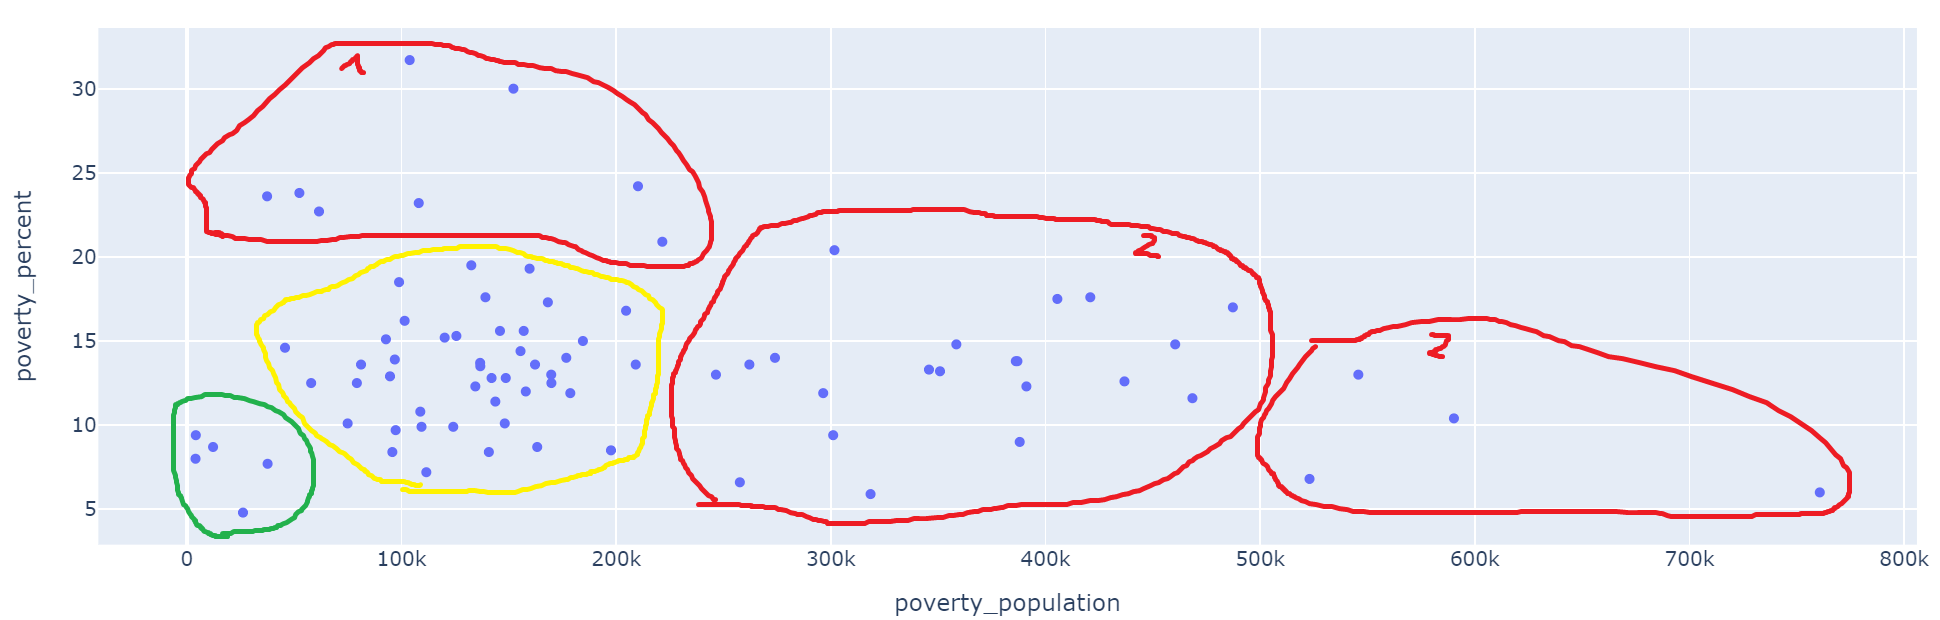

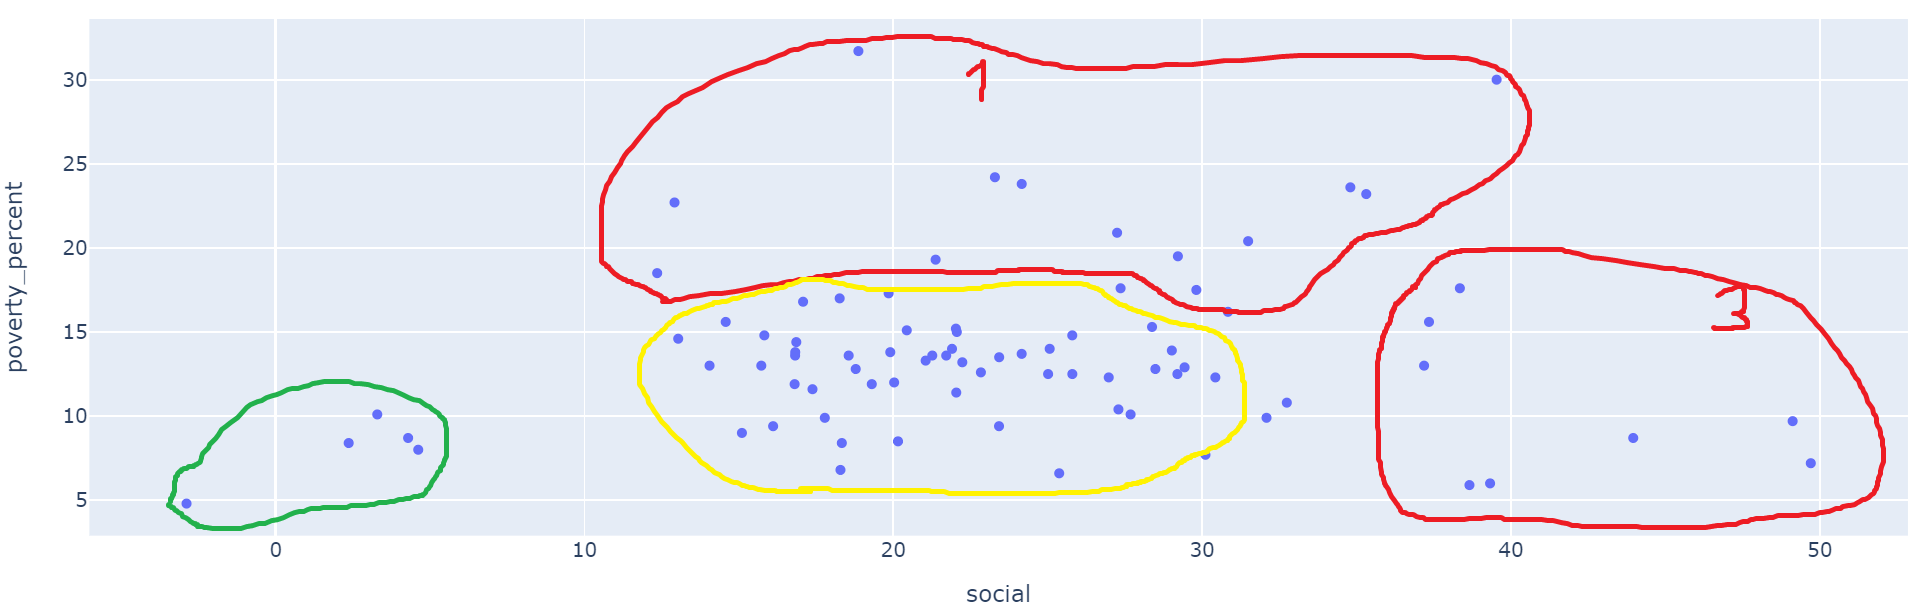

Про feature social обьясню позже

In [ ]:
# Берем данные за 2020, чтобы делать выводы на 2021
test = main[main.year == 2020].copy()

Я пробовал запускать кластеризацию по разроненным данным малообеспеченных/социально-незащищенных, но такой результат сложно интерперетировать.
Приведу ее в качестве baseline решения

## baseline

In [ ]:
cluster_df = test.reset_index(drop=True)
# Отложим метки регионов
save_region_data = cluster_df.loc[:, ['region']].reset_index(drop=True)
cluster_df.drop(['region'], axis=1, inplace=True)

In [ ]:
cluster_df

In [ ]:
# подготовим данные к кластеризации
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
cluster_df_scaled = pd.DataFrame(ss.fit_transform(
    cluster_df), columns=cluster_df.columns)
# определяем метод главных компонент с двумя компонентами
pca = PCA(n_components=0.9)
# обучаем алгоритм на наших данных
X_pca = pca.fit_transform(cluster_df_scaled)

In [ ]:
# Определим число кластеров
from sklearn import metrics
from sklearn.cluster import KMeans
# проходимся циклом по всем нужным нам значениям количества кластеров
ans = {'sil': (0, 0), 'CH': (0, 0), 'DB': (0, 100)}
for i in range(2, 11):
    # обучаем модель k-means с текущим количеством кластеров
    km = KMeans(n_clusters=i, random_state=1).fit(X_pca)
    # предсказываем метки
    y_pred = km.labels_
    # выводим результат для коэффициента силуэта
    new_sil = metrics.silhouette_score(X_pca,  y_pred)
    new_CH = metrics.calinski_harabasz_score(X_pca, y_pred)
    new_DB = metrics.davies_bouldin_score(X_pca, y_pred)
    print(i, new_sil, new_CH, new_DB)
    if new_sil > ans['sil'][1]:
        ans['sil'] = (i, new_sil)
    if new_CH > ans['CH'][1]:
        ans['CH'] = (i, new_CH)
    if new_DB < ans['DB'][1]:
        ans['DB'] = (i, new_DB)
print(ans)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=1)
kmeans.fit(X_pca)
cluster_res = cluster_df.copy()
cluster_res['cluster'] = kmeans.labels_
cluster_res = pd.concat(
    [cluster_res.reset_index(drop=True), save_region_data], axis=1)

In [ ]:
px.scatter(cluster_res, x='poverty_population', y='poverty_percent', color='cluster',
           hover_data={'region': True})

Регионы как-то делятся на кластеры. Есть кластеры с большим процентом бедности и большим числом бедностей. Но как выделяются остальные кластеры разобрать сложно.

## Введение параметра социальной незащищенности social


Соберем собственную формулу "нуждаемости региона в помощи"

In [ ]:
test = main[main.year == 2020].copy()
# Собираем фактор социально-незащищенных: неработающих и с плохими условиями жилья. Формула подбиралась "на глаз", так чтобы лучше разделить регионы
test['social'] = test['senior']*2+test.disabled_percent*2 + \
    (-test.living_rooms+test.cramped_and_bad_conditions -
     test.counting_on_housing_from_gov)/2
test = test.drop(['senior', 'disabled_percent', 'living_rooms',
                 'cramped_and_bad_conditions', 'counting_on_housing_from_gov'], axis=1)

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
cluster_df = test.reset_index(drop=True)
# Отложим метки регионов
save_region_data = cluster_df.loc[:, ['region']].reset_index(drop=True)
cluster_df.drop(['region'], axis=1, inplace=True)

# подготовим данные к кластеризации
ss = StandardScaler()
cluster_df_scaled = pd.DataFrame(ss.fit_transform(
    cluster_df), columns=cluster_df.columns)
# определяем метод главных компонент с двумя компонентами
pca = PCA(n_components=0.9)
# обучаем алгоритм на наших данных
X_pca = pca.fit_transform(cluster_df_scaled)

# Определим число кластеров
# проходимся циклом по всем нужным нам значениям количества кластеров
ans = {'sil': (0, 0), 'CH': (0, 0), 'DB': (0, 100)}
for i in range(2, 11):
    # обучаем модель k-means с текущим количеством кластеров
    km = KMeans(n_clusters=i, random_state=1).fit(X_pca)
    # предсказываем метки
    y_pred = km.labels_
    # выводим результат для коэффициента силуэта
    new_sil = metrics.silhouette_score(X_pca,  y_pred)
    new_CH = metrics.calinski_harabasz_score(X_pca, y_pred)
    new_DB = metrics.davies_bouldin_score(X_pca, y_pred)
    print(i, new_sil, new_CH, new_DB)
    if new_sil > ans['sil'][1]:
        ans['sil'] = (i, new_sil)
    if new_CH > ans['CH'][1]:
        ans['CH'] = (i, new_CH)
    if new_DB < ans['DB'][1]:
        ans['DB'] = (i, new_DB)
print(ans)

Круто, что по метрикам выделется именно 5 кластеров, как хотелось

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pca)
cluster_res = cluster_df.copy()
cluster_res['cluster'] = kmeans.labels_
cluster_res = pd.concat(
    [cluster_res.reset_index(drop=True), save_region_data], axis=1)

In [ ]:
px.scatter(cluster_res, x='poverty_population', y='poverty_percent', color='cluster',
           hover_data={'region': True})

In [ ]:
px.scatter(cluster_res, x='social', y='poverty_percent', color='cluster',
           hover_data={'region': True})

In [ ]:
px.scatter_3d(cluster_res, x='poverty_population', z='poverty_percent', y='social', color='cluster',
              hover_data={'region': True})

Получилось?! Есть кластеры:
1) с наибольшим процентом бедных - 4
2) наибольшим количеством бедных - 1
3) наиболее социально-незащищенных - 2
4) благополучные (и маленькие) - 3
5) промежуточный - 0

## Прогноз

Продлим основные ряды процента бедных и популяции до 2021 года

### Принцип алгоритма для одного региона


In [ ]:
poverty_percent_to_2021 = main[main['region']
                               == 'Белгородская область'].iloc[:, 1:3]
poverty_percent_to_2021.set_index('year', inplace=True)
poverty_percent_to_2021

In [ ]:
# импортируем библиотеку
from statsmodels.tsa.seasonal import seasonal_decompose
# производим декомпозицию временного ряда
decomposition = seasonal_decompose(poverty_percent_to_2021, period=1)
fig = decomposition.plot()
plt.show()

In [ ]:
# Данные делим по порядку
train_df = poverty_percent_to_2021.iloc[:-1]
test_df = poverty_percent_to_2021.iloc[-1:]
train_df.shape, test_df.shape

In [ ]:
# Стационарность
from statsmodels.tsa.stattools import adfuller


def adfuller_test(df):
    test1 = adfuller(df)
    print("adf: ", test1[0])
    print("p-value: ", test1[1])
    print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")


adfuller_test(train_df)

In [ ]:
# Автоподбор параметров
import pmdarima as pm
smodel = pm.auto_arima(
    train_df,
    start_p=0,
    d=None,
    start_q=0,
    max_p=5,
    max_d=5,
    max_q=5,
    test="adf",
    error_action="ignore",
    trace=True
)
smodel_fit = smodel.fit(train_df)
# Предсказание AR
ar_pred = smodel_fit.predict(1)

In [ ]:
# Предсказание экспонентой
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train_df)
alpha = 0.7
model = ses.fit(smoothing_level=alpha, optimized=False)
exp_pred = model.forecast(1)
exp_pred

In [ ]:
# Сравнение результатов
from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_percentage_error(test_df, ar_pred)*100,
      mean_absolute_percentage_error(test_df, exp_pred)*100)

### Проверю, насколько хорошо предсказываются значения для всех регионов

In [ ]:
# Сохранял получающиеся значения для оценки. Не необходимо, но интересно
test_pred = {'region': [], 'y_test': [], 'pred': [], "MAPE": []}
for region in main.region.unique():

    test_pred['region'].append(region)
    poverty_percent_to_2021 = main[main['region'] == region].iloc[:, 1:3]
    poverty_percent_to_2021.set_index('year', inplace=True)

    train_df = poverty_percent_to_2021.iloc[:-1]
    test_df = poverty_percent_to_2021.iloc[-1:]
    test_pred['y_test'].append(test_df.values[0])

    smodel = pm.auto_arima(
        train_df,
        start_p=0,
        d=None,
        start_q=0,
        max_p=4,
        max_q=4,
        test="pp",
        error_action="ignore"
    )
    smodel_fit = smodel.fit(train_df)
    ar_pred = smodel_fit.predict(1)

    from statsmodels.tsa.api import SimpleExpSmoothing
    ses = SimpleExpSmoothing(train_df)
    model = ses.fit(smoothing_level=0.7, optimized=False)
    exp_pred = model.forecast(1)

    pred = (min(ar_pred.values[0], np.array(exp_pred)[0]))
    test_pred['pred'].append(pred)

    test_pred['MAPE'].append(mean_absolute_percentage_error(
        test_df.values[0], [pred]).round(4)*100)

test_pred_df = pd.DataFrame(test_pred)
print(f'Средний MAPE для предсказаний: {test_pred_df.MAPE.mean()}')

Хороший результат. Сделаем предсказания для 2021 года и добавим в main 

### Предсказания poverty_percent на 2021

In [ ]:
pred_dic = {'region': [], 'poverty_percent': []}
for region in main.region.unique():

    pred_dic['region'].append(region)

    poverty_percent_to_2021 = main[main['region'] == region].iloc[:, 1:3]
    poverty_percent_to_2021.set_index('year', inplace=True)

    smodel = pm.auto_arima(
        poverty_percent_to_2021,
        start_p=0,
        d=None,
        start_q=0,
        max_p=4,
        max_q=4,
        test="pp",
        error_action="ignore"
    )
    smodel_fit = smodel.fit(poverty_percent_to_2021)
    ar_pred = smodel_fit.predict(1)

    from statsmodels.tsa.api import SimpleExpSmoothing
    ses = SimpleExpSmoothing(poverty_percent_to_2021)
    model = ses.fit(smoothing_level=0.7, optimized=False)
    exp_pred = model.forecast(1)

    pred = (min(ar_pred.values[0], np.array(exp_pred)[0]))
    pred_dic['poverty_percent'].append(pred)

pred_df = pd.DataFrame(pred_dic)

In [ ]:
# В сделанном ранее df c популяциями есть 2021 год
pred_df = pred_df.merge(pop_df[pop_df['year'] == 2021])

In [ ]:
pred_df['poverty_population'] = pred_df['poverty_percent'] / \
    100 * pred_df['population']
pred_df.drop(['population', 'year'], axis=1)

## Кластеризация с предсказанными значениями бедностей

In [ ]:
test = main[main.year == 2020].drop(['poverty_population', 'poverty_percent'], axis=1).merge(
    pred_df.drop(['population', 'year'], axis=1), on='region')
test['social'] = test['senior']*2+test.disabled_percent*2 + \
    (-test.living_rooms+test.cramped_and_bad_conditions -
     test.counting_on_housing_from_gov)/2
test = test.drop(['senior', 'disabled_percent', 'living_rooms',
                 'cramped_and_bad_conditions', 'counting_on_housing_from_gov'], axis=1)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
cluster_df = test.reset_index(drop=True)
# Отложим метки регионов
save_region_data = cluster_df.loc[:, ['region']].reset_index(drop=True)
cluster_df.drop(['region'], axis=1, inplace=True)

# подготовим данные к кластеризации
ss = StandardScaler()
cluster_df_scaled = pd.DataFrame(ss.fit_transform(
    cluster_df), columns=cluster_df.columns)
# определяем метод главных компонент с двумя компонентами
pca = PCA(n_components=0.9)
# обучаем алгоритм на наших данных
X_pca = pca.fit_transform(cluster_df_scaled)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pca)
cluster_res['pred_cluster'] = kmeans.labels_

In [ ]:
px.scatter(cluster_res, x='poverty_population', y='poverty_percent', color='pred_cluster',
           hover_data={'region': True})

Курганская область ушла из кластера наибольшего процента бедности. Минимальное, конечно, изменение, но всё же значимо
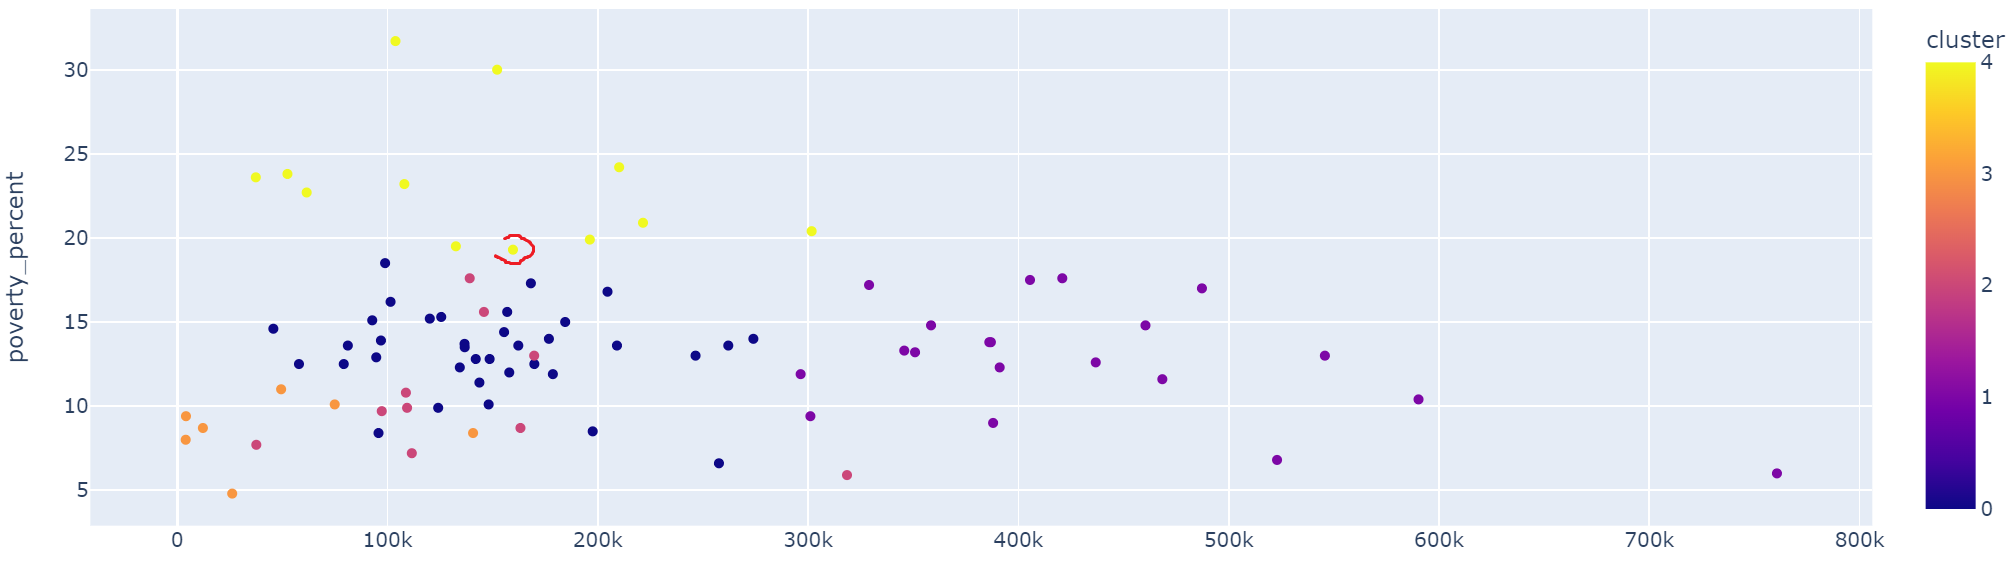
(график на цифрах 2020 года)

In [ ]:
px.scatter_3d(cluster_res, x='poverty_population', z='poverty_percent', y='social', color='pred_cluster',
              hover_data={'region': True})

Зафиксируем
1) с наибольшим процентом бедных - 3
2) наибольшим количеством бедных - 2
3) наиболее социально-незащищенных -0
4) благополучные - 4
5) промежуточный (средние значения) - 1

In [ ]:
cluster_res

In [ ]:
lib = cluster_res.groupby('pred_cluster').agg({'region': [tuple, len],
                                               'poverty_percent': np.mean,
                                               'poverty_population': np.mean, 'social': np.mean})
lib

# Сравним кластеры

In [ ]:
from scipy.stats import shapiro

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

data = cluster_res.drop(['cluster', 'region', 'year'], axis=1)
for col in data.columns[:3]:
    print(col)
    _, p = shapiro(data[col])
    print('p=%.3f' % p)

    # Интерпретация

    if p > alpha:
        print(H0)
    else:
        print(Ha)

In [ ]:
data.hist(figsize=(16, 14))

Значит для первых двух признаков используем тест суммы рангов Вилкоксона, для третьего - Независимый T-тест. Сравним выделяющиеся по этим признакам кластеры с "безопасным"

In [ ]:
from scipy.stats import ranksums


def wilk(df, cluster, parameter):

    H0 = f', а значит {parameter} в определяемом кластере {cluster} не отличается от его же в среднем кластере\n'
    Ha = f', а значит {parameter} в определяемом кластере {cluster} больше, чем в среднем\n'

    print('\n' + "*** Результаты теста суммы рангов Вилкоксона ***")
    test_results = ranksums(df[df['pred_cluster'] == cluster][parameter],
                            df[df['pred_cluster'] == 1][parameter], alternative='greater')

    p = round(test_results[1], 2)

    if p > alpha:
        print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу{H0}")
    else:
        print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу{Ha}")


print('Проверим, что относительная бедность в кластере 3 больше, чем в "среднем" кластере 1')
wilk(data, 3, 'poverty_percent')
print('Проверим, что абсолютное число малоимущих в кластере 2 больше, чем в "среднем" кластере 1')
wilk(data, 2, 'poverty_population')

In [ ]:
from scipy.stats import ttest_ind


def t_test(df, cluster, parameter):

    H0 = f', а значит {parameter} в определяемом кластере {cluster} не отличается от его же в среднем кластере\n'
    Ha = f', а значит {parameter} в определяемом кластере {cluster} больше, чем в среднем\n'

    print('\n' + "*** Результаты независимого T-теста ***")
    test_results = ttest_ind(df[df['pred_cluster'] == cluster][parameter],
                             df[df['pred_cluster'] == 1][parameter], alternative='greater')

    p = round(test_results[1], 2)

    if p > alpha:
        print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу{H0}")
    else:
        print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу{Ha}")


print('Проверим, что социальное неблагополучие в кластере 0 больше, чем в "среднем" кластере 1')
t_test(data, 0, 'social')

#  Экономика

## Валовой региональный продукт

In [ ]:
main = pd.read_pickle('main.pkl')

In [ ]:
grp_df = pd.read_excel(
    'data/gross_regional_product_1996_2020.xls', skiprows=[0, 1])
grp_df = grp_df.rename({grp_df.columns[0]: 'region'}, axis=1)
grp_df = unified_regions(grp_df)
# конвертируем таблицу wide-to-long
grp_df = pd.melt(grp_df, id_vars='region',
                 var_name='year', value_name='grp_value')
grp_df.year = grp_df.year.apply(int)
grp_df

In [ ]:
grp_df.info()

In [ ]:
grp_df.grp_value.value_counts(dropna=False)

В данных есть пропуски и нули. К сожалению, на слишком больших промежутках, чтобы как-то разумно их заменить. Заменим 0 на NA

In [ ]:
grp_df = grp_df.replace(0, np.nan).dropna(how='any', axis=0)

In [ ]:
set(main.region.unique())-(set(disabled.region.unique()))

In [ ]:
main = main.merge(grp_df, how='left', on=['region', 'year'])
px.imshow(main.corr(numeric_only=True), color_continuous_scale='Bluered')

Прослеживается зависимость процента бедности от ВРП

In [ ]:
px.scatter(main, y='poverty_percent', x='grp_value',
           log_y=True, hover_data=['region', 'year'])

Может даже логарифмическая зависимость? Что если убрать крайние значения?

In [ ]:
main.grp_value.quantile([0.1, 0.9])

In [ ]:
vis = main[main.grp_value.between(14004.32, 509867.48)]
px.imshow(vis.corr(numeric_only=True), color_continuous_scale='Bluered')

In [ ]:
fig = px.scatter(vis, y='poverty_percent', x='grp_value', log_y=True, hover_data=[
                 'region', 'year'], trendline="ols", trendline_options=dict(log_x=True))
fig.show()
results = px.get_trendline_results(fig)
print(results)
results.px_fit_results.iloc[0].summary()

Есть явная зависимость бедности региона от значения ВРП

## Оборот розничной торговли на душу населения

In [ ]:
retail_turnover = pd.read_excel(
    'data/retail_turnover_per_capita_2000_2021.xls', skiprows=[0, 1, 3])
retail_turnover

In [ ]:
retail_turnover = retail_turnover.drop(retail_turnover.columns[1], axis=1)

In [ ]:
retail_turnover = retail_turnover.rename(
    {retail_turnover.columns[0]: 'region'}, axis=1)
retail_turnover = unified_regions(retail_turnover)

In [ ]:
# конвертируем таблицу wide-to-long
retail_turnover_df = pd.melt(
    retail_turnover, id_vars='region', var_name='year', value_name='retail_turnover')
retail_turnover_df.year = retail_turnover_df.year.apply(int)

In [ ]:
set(main.region.unique())-(set(retail_turnover_df.region.unique()))

In [ ]:
main = main.merge(retail_turnover_df, how='left', on=['region', 'year'])

In [ ]:
main.retail_turnover.value_counts(dropna=False)

При просмотре получившейся таблицы видно, что 0 это данные в областях-матрёшках. Можно вычислить эти значения, но довольно муторно. Думаю можно пропустить эти строчки. NaN для годов раньше 1999 тоже опустим, остальные заменим первым валидным значением

In [ ]:
vis = main[main['retail_turnover'] != 0]
vis = vis[vis['year'] > 1999]
vis['retail_turnover'] = vis['retail_turnover'].bfill()
px.imshow(vis.corr(numeric_only=True), color_continuous_scale='Bluered')

In [ ]:
px.scatter(vis, y='poverty_percent', x='retail_turnover',
           hover_data=['region', 'year'])

Как же приятно работать с такими корреляциями! Попробуем аппроксимировать

In [ ]:
fig = px.scatter(vis, y='poverty_percent', x='retail_turnover', log_y=True, hover_data=[
                 'region', 'year'], trendline="ols", trendline_options=dict(log_x=True))
fig.show()
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()

In [ ]:
fig = px.scatter(vis, y='poverty_percent', x='retail_turnover', log_y=True, hover_data=[
                 'region', 'year'], trendline="ols", trendline_options=dict(log_x=True))
fig.show()
results = px.get_trendline_results(fig)
print(results)
results.px_fit_results.iloc[0].summary()

Видим, что оборот розничной торговли также коррелирует с процентом бедности в регионе. Хотя он и с ВРП достаточно скоррелирован (0.5)

# Выводы

## Проведен разведывательный анализ данных, найдены зависимости, такие как

В среднем, после 2000 года каждый год относительные и абсолютные значения бедности уменьшаются, а экономические показатели растут
В малообеспеченных регионах:
* хуже жилищные условия
* хуже экономические показатели
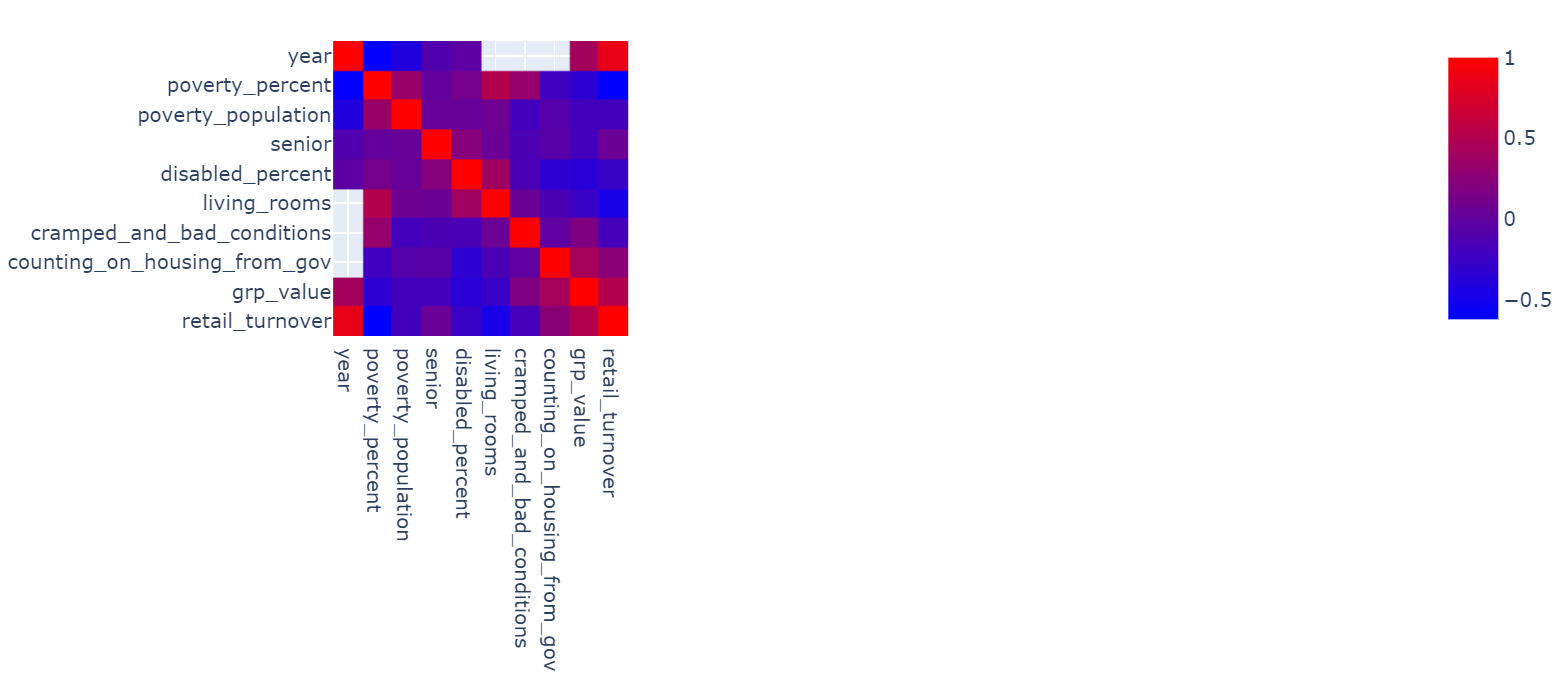

## Проведена кластеризация регионов

Определены кластеры регионов, которые наиболее остро нуждаются в помощи малообеспеченным/неблагополучным слоям населения
* Наибольшее относительное число малообеспеченных

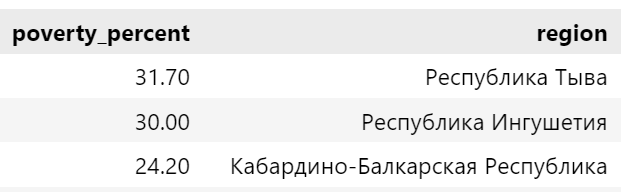

* Наибольшее абсолютное число малообеспеченных

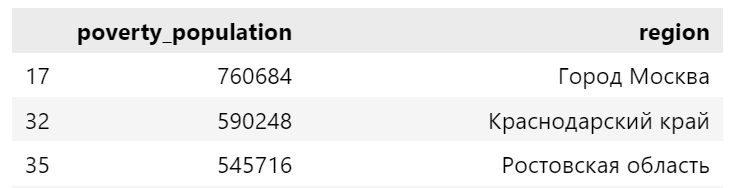

* Выше социальные трудности в регионах:

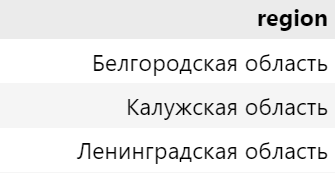

## Определение кластеров регионов подтверждено статистическими методами